## Imports

In [44]:
import numpy as np

# Layer 구조 설정
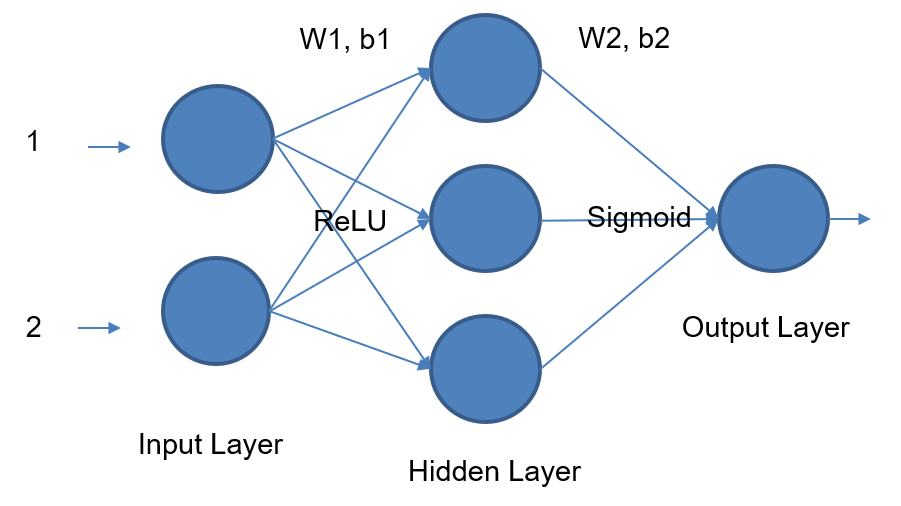

In [112]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"},
]

# 각 층의 가중치, 편향 초기화

In [113]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {} # 층 별 가중치와 편향값을 저장할 딕셔너리 
    
    # 모든 층 순회
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        layer_input_size = layer["input_dim"] # 입력 차원 (이전 층 뉴런의 수)
        layer_output_size = layer["output_dim"] # 출력 차원 (뉴런의 수)
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [114]:
params_values = init_layers(NN_ARCHITECTURE)
params_values

{'W1': array([[-0.01423588,  0.20572217],
        [ 0.02832619,  0.1329812 ],
        [-0.01546219, -0.00690309]]),
 'b1': array([[ 0.07551805],
        [ 0.08256466],
        [-0.01130692]]),
 'W2': array([[-0.23678376, -0.01670494,  0.0685398 ]]),
 'b2': array([[0.00235001]])}

# 활성함수 설정

In [115]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

## 1-layer Feed Forward

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$
$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$


$$
l: layers, W: weights, B: bias
$$

In [116]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # 활성함수 입력 전 input 값 연산
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # 활성함수 선택
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # activation A 행렬과 중간의 Z 행렬
    return activation_func(Z_curr), Z_curr

## 예시
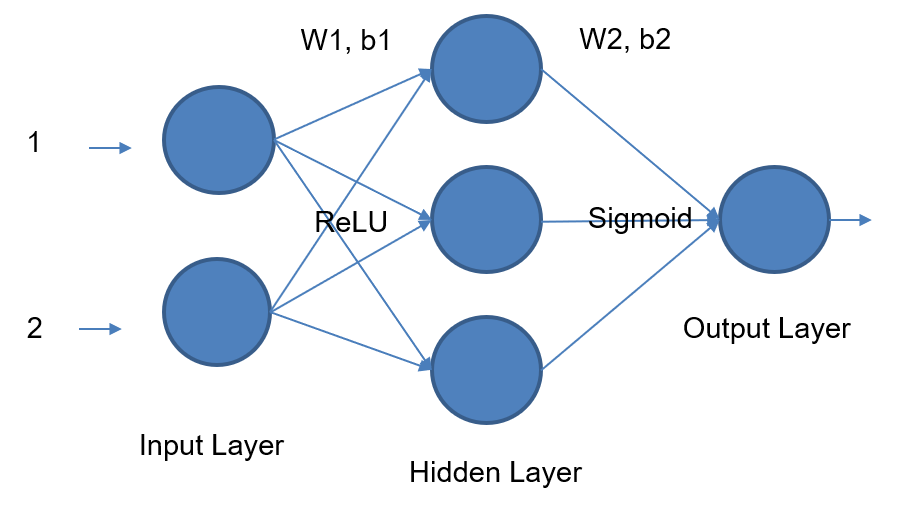

In [117]:
# input data
data1 = np.array([1,2]).reshape(2,1)
data1

array([[1],
       [2]])

In [118]:
# 첫 번째 층의 가중치와 편향
params_values['W1'], params_values['b1']

(array([[-0.01423588,  0.20572217],
        [ 0.02832619,  0.1329812 ],
        [-0.01546219, -0.00690309]]),
 array([[ 0.07551805],
        [ 0.08256466],
        [-0.01130692]]))

In [119]:
# a1, z1 출력
a1, z1 = single_layer_forward_propagation(data1, params_values['W1'], params_values['b1'], activation = 'relu')
a1, z1

(array([[0.47272651],
        [0.37685325],
        [0.        ]]),
 array([[ 0.47272651],
        [ 0.37685325],
        [-0.04057528]]))

In [120]:
# a2, z2 (결과값)출력
a2, z2 = single_layer_forward_propagation(a1, params_values['W2'], params_values['b2'], activation = 'sigmoid')
a2, z2

(array([[0.47106256]]), array([[-0.11587926]]))

## Full Feed Forward

In [121]:
def full_forward_propagation(X, params_values, nn_architecture):
    # back propagation에서 연산에 사용할 A, Z값 저장
    memory = {}
    # 첫 layer에서 입력값은 X값
    A_curr = X
    
    # 층 별 forward propagation 수행
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        # 층이 올라가면 이전 층의 A값으로 수정
        A_prev = A_curr
        
        # 값 불러와서 연산 수행
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # memory에 층 별 출력값 저장
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # 예측값과 가중치 dictionary 반환
    return A_curr, memory

In [122]:
A_curr, memory = full_forward_propagation(data1, params_values, NN_ARCHITECTURE)
A_curr, memory

(array([[0.47106256]]),
 {'A0': array([[1],
         [2]]),
  'Z1': array([[ 0.47272651],
         [ 0.37685325],
         [-0.04057528]]),
  'A1': array([[0.47272651],
         [0.37685325],
         [0.        ]]),
  'Z2': array([[-0.11587926]])})

## Cost Function
- 분류모델 -> Binary Cross Entropy
- 이진 분류모델에서 오분류하는 경우에 loss값을 크게 해주는 log함수


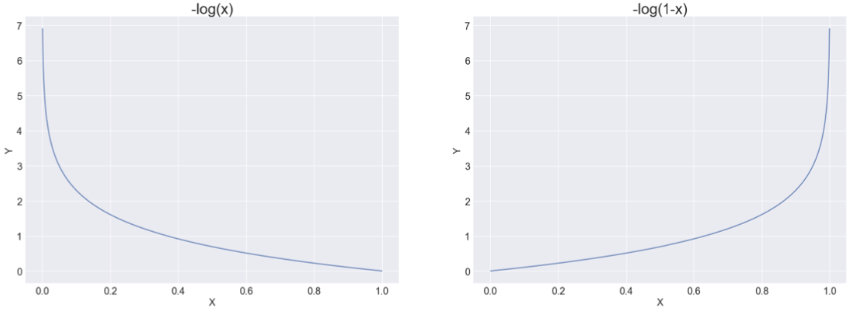
$$
BCE = -\frac{1}{m}[ylog(\hat{y})+(1-y)log(1-\hat{y})]
$$

In [149]:
def get_cost_value(Y_hat, Y):
    # 표본의 수
    m = Y_hat.shape[1]
    
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

## Calculating accuracy

In [150]:
# 확률에 따라 class 분류
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [151]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    # 전체 분류 중 잘 분류한 비율
    return (Y_hat_ == Y).all(axis=0).mean()

## Single layer backward propagation


$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



In [127]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # 활성함수 미분 계산
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # dW 계산
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # db 계산
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # 이전 층의 dA 계산
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

# 예시
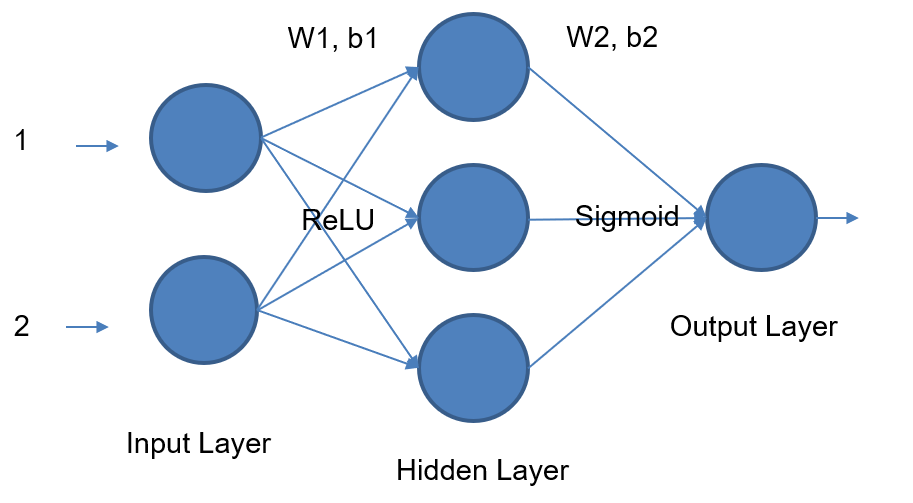


$$ dA = \frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$
- 추정치 $\hat{Y}$는 확률 -> 0.2 실제 값 $Y$는 0일 때

### 두번째 층

In [143]:
memory

{'A0': array([[1],
        [2]]),
 'Z1': array([[ 0.47272651],
        [ 0.37685325],
        [-0.04057528]]),
 'A1': array([[0.47272651],
        [0.37685325],
        [0.        ]]),
 'Z2': array([[-0.11587926]])}

In [144]:
dA = -(-(1-0)/(1-0.2))
dA

1.25

In [134]:
Z_curr = memory['Z2']
Z_curr

array([[-0.11587926]])

In [135]:
A_prev = memory['A1']

In [146]:
dA_prev2, dW_curr2, db_curr2 = single_layer_backward_propagation(dA, params_values['W2'], params_values['b2'], Z_curr, A_prev, activation='sigmoid')
dA_prev2, dW_curr2, db_curr2

(array([[-0.07374708],
        [-0.00520281],
        [ 0.02134694]]),
 array([[0.14723222, 0.11737218, 0.        ]]),
 array([[0.31145328]]))

### 첫번째 층

In [147]:
dA_prev1, dW_curr1, db_curr1 = single_layer_backward_propagation(dA_prev2, params_values['W1'], params_values['b1'], memory['Z1'], memory['A0'], activation='relu')
dA_prev1, dW_curr1, db_curr1

(array([[ 0.00090248],
        [-0.01586329]]),
 array([[-0.07374708, -0.14749416],
        [-0.00520281, -0.01040562],
        [ 0.        ,  0.        ]]),
 array([[-0.07374708],
        [-0.00520281],
        [ 0.        ]]))

## Full backward propagation

$$
Gradient_{w_l} = \frac{\partial Cost}{\partial w_L} = \frac{\partial Cost}{\partial a_L} * \frac{\partial a_L}{\partial z_L} * \frac{\partial z_L}{\partial w_L}
$$
$$
\frac{\partial a_L}{\partial z_L} = (g(z_L))' = g'(z_L)
$$
$$
\frac{\partial z_L}{\partial w_L} = (w_L*a_{L-1}+b_L)' = a_{L-1}
$$


$$
Gradient_{w_L} = \frac{\partial Cost}{\partial w_L}
$$
$$
Gradient_{b_L} = \frac{\partial Cost}{\partial b_L}
$$
$$
w_L = w_L - \alpha * \frac{\partial Cost}{\partial w_L}
$$
$$
b_L = b_L - \alpha * \frac{\partial Cost}{\partial b_L}
$$

$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [17]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    # gradient를 저장할 dict
    grads_values = {}
    
    # 표본 수
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
    # 경사하강법을 위한 초기 dA값 설정 (cost function을 y_hat에 대해 편미분)
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        # memory 불러오기
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        # 가중치, 편향 값 불러오기
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        # gradient 저장
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Updating parameter values

In [18]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # 모든 층 가중치 업데이트
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## 학습 함수 만들기

In [19]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # 초기 가중치, 파라미터 설정
    params_values = init_layers(nn_architecture, 2)
    # cost function 값 저장 
    # 학습 도중 accuracy 저장 
    cost_history = []
    accuracy_history = []
    
    # epochs 수 만큼 학습 반복
    for i in range(epochs):
    
        Y_hat, memory = full_forward_propagation(X, params_values, nn_architecture)
        
        # 모델 평가 지표 저장
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # gradient 계산
        grads_values = full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture)
        # 가중치 업데이트
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        # history는 매 50회 에폭마다 저장
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

# 모델 Test

### Imports

In [27]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

from sklearn.metrics import accuracy_score

### Settings

In [28]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

### Create artificial dataset

In [29]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [30]:
X.shape

(1000, 2)

In [31]:
y.shape

(1000,)

### Auxiliary plotting function

In [32]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

### Visualization of the data set

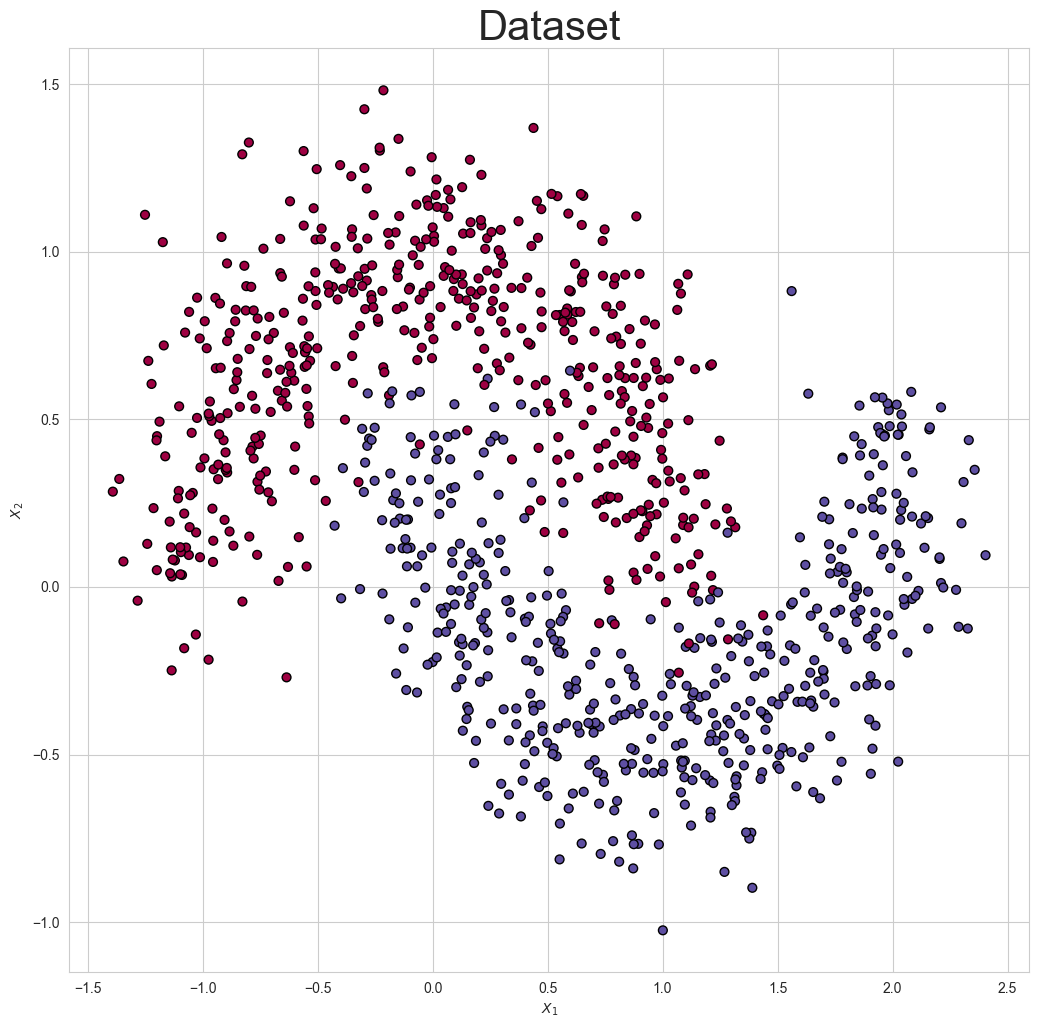

In [33]:
make_plot(X, y, "Dataset")

# Layer 구조 설정

In [ ]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [34]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01,verbose = True)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

In [36]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [37]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test))

Test set accuracy: 0.98 


## Visualisation of the learning process

### Settings

In [38]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"

### Definition of grid boundaries

In [39]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

### NumPy Model

In [40]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [41]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, True, callback_numpy_plot, )

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

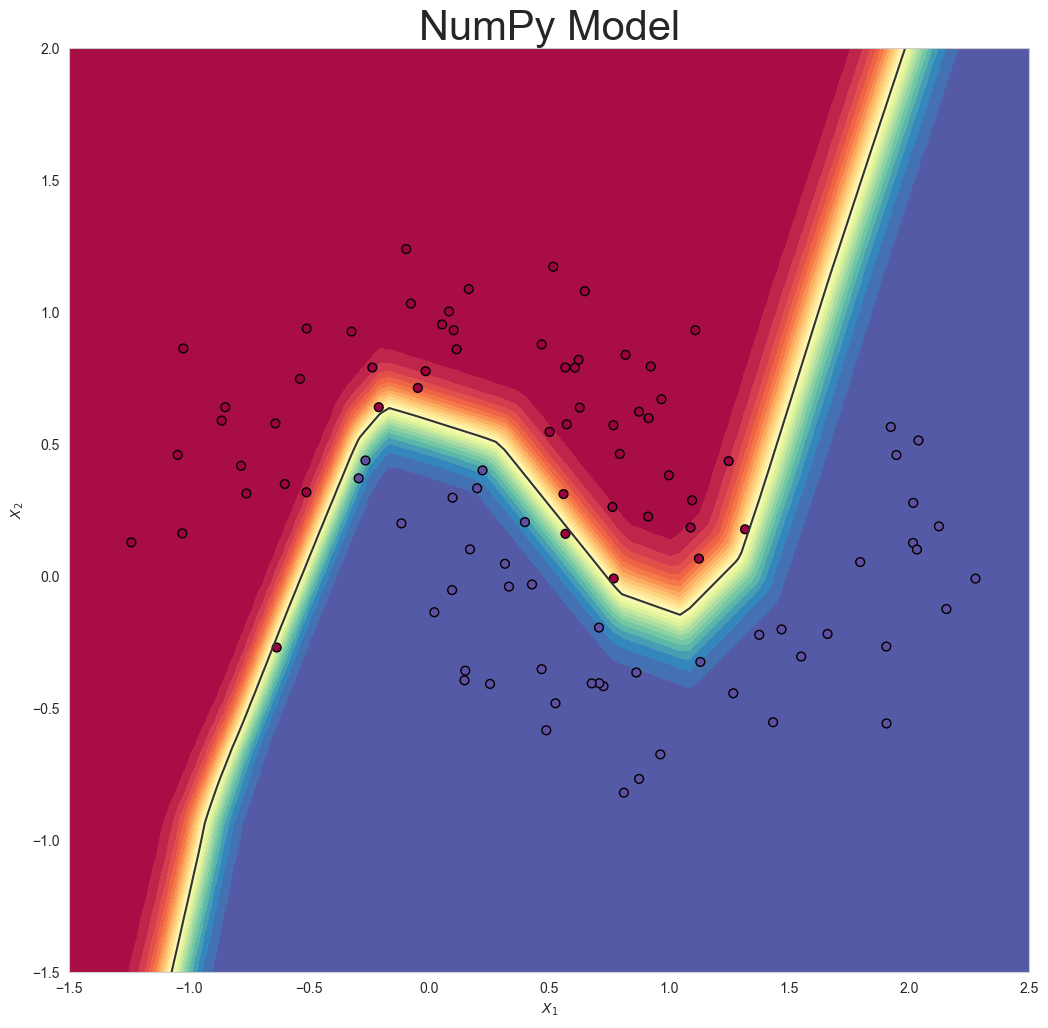

In [42]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)


# 한계
1. Optimizer의 부재

## Thank you
---